In [59]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString

# functions

## tripleg

In [82]:
def triplegs_split(df, max_length=500): # Split into 500
    
    def split_geom_data(geom, max_length):
        points = geom.split(',')
        sub_tpls = [','.join(points[i:i + max_length]) for i in range(0, len(points), max_length)]
        return sub_tpls

    new_rows = []
    for _, row in df.iterrows():
        geoms = split_geom_data(row['geom'], max_length)
        for geom in geoms:
            new_row = row.copy()
            new_row['geom'] = geom
            new_rows.append(new_row)

    return pd.DataFrame(new_rows)

In [83]:
def process_triplegs_data(dataframe, time_column='started_at'):
    """
    Preprocess triplegs data to filter based on a specific date range and convert LINESTRING data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing triplegs data.
        time_column (str): Column name for timestamps to filter and process.

    Returns:
        list: A flattened list of integer coordinate sequences extracted from LINESTRING geometries.
    """
    # Convert the time column to a datetime object
    dataframe[time_column] = pd.to_datetime(dataframe[time_column])

    # Define the start date and compute the end date (30 days later)
    initial_date = pd.to_datetime('1900-01-01').tz_localize('UTC')
    cutoff_date = initial_date + pd.Timedelta(days=30)

    # Filter rows to keep only those within the specified date range
    filtered_data = dataframe.loc[
        (dataframe[time_column] >= initial_date) & (dataframe[time_column] < cutoff_date)
    ].copy()  # .copy() ensures modifications won't trigger a warning

    # Function to transform LINESTRING into tuples of integer coordinates
    def parse_linestring(linestring):
        # Extract coordinate pairs from the LINESTRING using regex
        coordinates = re.findall(r'(\d+\.\d+ \d+\.\d+)', linestring)
        # Convert the extracted coordinates to integer tuples
        int_coords = [tuple(map(int, map(float, coord.split()))) for coord in coordinates]
        return int_coords  # Return as a list of tuples
    
    # Apply the transformation to the 'geom' column
    filtered_data['geom'] = filtered_data['geom'].apply(parse_linestring)

    # Group sequences by user ID and collect into lists
    grouped_sequences = filtered_data.groupby('user_id')['geom'].apply(list).tolist()

    # Flatten the nested lists into a single list of coordinate tuples
    all_coordinates = [coords for sequence in grouped_sequences for coords in sequence]

    return all_coordinates

In [84]:
def tripperuser(sequences):
    
    # Convert sequences into a DataFrame where each row is a tripleg and each tripleg has a user_id
    data = []
    for user_id, sequence in enumerate(sequences):  # Use user_id as the identifier
        for tripleg in sequence:
            data.append([user_id, tripleg])
    
    # Create DataFrame
    triplegs_df = pd.DataFrame(data, columns=['user_id', 'tripleg'])
    
    # Count triplegs by user_id
    user_triplegs_count = triplegs_df['user_id'].value_counts().head(15)
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    user_triplegs_count.plot(kind='bar', color='skyblue')
    plt.title('Number of Triplegs per User')
    plt.xlabel('User ID')
    plt.ylabel('Number of Triplegs')
    plt.show()

In [85]:
def movden(sequences):
    # Convert coordinates to GeoDataFrame for visualization
    geo_data = [Point(coord) for seq in sequences for coord in seq]
    gdf = gpd.GeoDataFrame(geometry=geo_data)
    gdf.plot(markersize=1, figsize=(8, 8))
    plt.title("Movement Density")
    plt.show()

In [86]:
def trip_duration(df):
    # Summary statistics
    print(df['duration'].describe())

    # Histogram of trip durations
    sns.histplot(df['duration'], bins=30, kde=True)
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Trip Durations')
    plt.show()

In [87]:
def duration_dayofweek(df):
    # Average duration by day of the week
    avg_duration_by_day = df.groupby('day_of_week')['duration'].mean().sort_values()
    print(avg_duration_by_day)

    # Visualization
    sns.barplot(x=avg_duration_by_day.index, y=avg_duration_by_day.values)
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Trip Duration (minutes)')
    plt.title('Average Trip Duration by Day of the Week')
    plt.xticks(rotation=45)
    plt.show()


In [88]:
def duration_date(df):
    df['date'] = df['started_at'].dt.date
    total_duration_per_day = df.groupby('date')['duration'].sum()

    # Adjust the figure size to make the plot longer
    plt.figure(figsize=(12, 6))  # Adjust width and height to suit your labels

    # Plot the total duration trend
    sns.lineplot(x=total_duration_per_day.index, y=total_duration_per_day.values)
    plt.xlabel('Date')
    plt.ylabel('Total Trip Duration (minutes)')
    plt.title('Total Trip Duration per Day')

    # Zero baseline
    plt.ylim(bottom=0)

    # Rotate x-axis labels to avoid overlap and ensure they fit
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()  # Automatically adjusts the layout to fit the labels
    plt.show()


In [89]:
def top_user_coord(df):
    avg_duration_per_user = df.groupby('user_id')['duration'].mean()
    top_100_users = avg_duration_per_user.nlargest(100).index

    # Filter the triplegs dataframe to include only top 100 users
    top_users_dftrip = df[df['user_id'].isin(top_100_users)]

    # Function to transform LINESTRING into tuples of integer coordinates
    def parse_linestring(linestring):
        # Extract coordinate pairs from the LINESTRING using regex
        coordinates = re.findall(r'(\d+\.\d+ \d+\.\d+)', linestring)
        # Convert the extracted coordinates to integer tuples
        int_coords = [tuple(map(int, map(float, coord.split()))) for coord in coordinates]
        return int_coords  # Return as a list of tuples

    # Apply the transformation to the 'geom' column
    top_users_dftrip['geom'] = top_users_dftrip['geom'].apply(parse_linestring)

    # Flatten the list of coordinates
    coordinates = [coord for geom in top_users_dftrip['geom'] for coord in geom]

    # Count the frequency of each coordinate
    coordinate_counts = Counter(coordinates)

    # Get the top most visited coordinates
    top_coordinates = coordinate_counts.most_common(10)  # Get top 10 most visited coordinates

    # Extract the coordinates and counts
    coords, counts = zip(*top_coordinates)
    coords_array = np.array(coords)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=coords_array[:, 0], y=coords_array[:, 1], hue=counts, sizes=(50, 500), legend=True, palette="crest")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Top 10 Most Visited Coordinates by Top 100 Users in Duration')
    plt.tight_layout()
    plt.show()

## sequences

In [68]:
def patterlen(df):
    
    # Function to calculate the length of a pattern based on parentheses
    def calculate_pattern_length(pattern):
        # Use regular expressions to count occurrences of pattern groups like `(x, y)`
        import re
        return len(re.findall(r'\(\d+, \d+\)', pattern))
    
    # Apply the function to calculate the length of each pattern
    df['Pattern_Length'] = df['Sequence'].apply(calculate_pattern_length)
    
    # Calculate the average length of the patterns
    average_length = df['Pattern_Length'].mean()
    
    print(f'The average length of the patterns is: {average_length}')

    import matplotlib.pyplot as plt
    
    plt.hist(df['Pattern_Length'], bins=range(1, df['Pattern_Length'].max() + 2), align='left', color='skyblue')
    plt.xlabel('Pattern Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pattern Lengths')
    plt.show()

    

In [69]:
def commonxy(newdf):
    
    newdf['xypair'] = list(zip(newdf['x'],newdf['y']))
    
    common_xy = newdf['xypair'].value_counts()
    
    common_xy = common_xy[common_xy > 1]
    
    # Convert common_xy (Series) into a DataFrame
    common_xy_df = common_xy.reset_index()
    
    # Rename the columns for clarity
    common_xy_df.columns = ['xy_pair', 'count']

    return common_xy_df


In [70]:
# Function to calculate distance between first and last coordinate pairs
def calculate_distance(coords):

        x1, y1 = map(int, coords[0])  # First coordinate
        x2, y2 = map(int, coords[-1])  # Last coordinate
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


In [71]:
def distancecalc(dftest):
    
    # Calculate the distance and add it as a new column
    dftest['distance'] = dftest['coordinates'].apply(calculate_distance)
    
    dftest['distance'].sort_values(ascending = False).head(15)
    
    return dftest

In [72]:
def first_last(coords):

        x1, y1 = map(int, coords[0])  # First coordinate
        x2, y2 = map(int, coords[-1]) 
        diff = 0

        if(x1 == x2):
            diff = abs(y2 - y1)

        if(y1 == y2):
            diff = abs(x2 - x1)

        if(diff == 0 or diff == 1 or diff == 2 or diff == 3):
            return diff


In [73]:
def heatmaptrans(df):
    
    transitions = []
    for seq in df['Sequence']:
        # Clean each item in the sequence by removing parentheses
        items = [re.sub(r'[^\w\s,]', '', item) for item in seq.split(", ")]
        transitions.extend(zip(items[:-1], items[1:]))
    
    transition_counts = Counter(transitions)
    
    # Get the 10 most common transitions
    top_10_transitions = transition_counts.most_common(10)
    print(top_10_transitions)
    
    # Extract the transition pairs and counts
    top_transitions, top_counts = zip(*top_10_transitions)
    
    # Convert to a DataFrame for easier manipulation
    top_transitions_df = pd.DataFrame(zip(top_transitions, top_counts), columns=['Transition', 'Count'])
    
    # Split the transitions into individual columns
    top_transitions_df[['x', 'y']] = pd.DataFrame(top_transitions_df['Transition'].to_list(), index=top_transitions_df.index)
    
    # Pivot the table to get a transition matrix for the top 10 transitions
    transition_matrix = top_transitions_df.pivot_table(index='x', columns='y', values='Count', fill_value=0)
    
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='.1f')
    plt.title('Top 10 Coordinates Heatmap')
    plt.xlabel('To')
    plt.ylabel('From')
    plt.show()

In [74]:
def hexbincoord(df):

    transitions = []
    for seq in df['Sequence']:
        # Clean each item in the sequence by removing parentheses
        items = [re.sub(r'[^\w\s,]', '', item) for item in seq.split(", ")]
        transitions.extend(zip(items[:-1], items[1:]))
    
    transition_counts = Counter(transitions)
       
    # Get the 10000 most common transitions
    top_transitions = transition_counts.most_common(10000)
    
    # Extract the transition pairs and counts
    top_transit, top_counts = zip(*top_transitions)
    
    # Convert to a DataFrame for easier manipulation
    top_transitions_df = pd.DataFrame(zip(top_transit, top_counts), columns=['Transition', 'Count'])
    
    # Split the transitions into individual columns
    top_transitions_df[['x', 'y']] = pd.DataFrame(top_transitions_df['Transition'].to_list(), index=top_transitions_df.index)
    top_transitions_df['x'] = pd.to_numeric(top_transitions_df['x'], errors='coerce')
    top_transitions_df['y'] = pd.to_numeric(top_transitions_df['y'], errors='coerce')

    
    plt.figure(figsize=(8, 6))
    plt.hexbin(top_transitions_df['x'], top_transitions_df['y'], gridsize=10, cmap='Blues')
    plt.colorbar(label='Density')
    plt.title("Hexbin Plot of Coordinates")
    
    x_ticks = range(int(min(top_transitions_df['x']) // 15) * 15, int(max(top_transitions_df['x']) // 15) * 15 + 15, 15)
    y_ticks = range(int(min(top_transitions_df['y']) // 15) * 15, int(max(top_transitions_df['y']) // 15) * 15 + 15, 15)
    
    plt.xticks(ticks=x_ticks)  # Set x-axis labels at intervals of 15
    plt.yticks(ticks=y_ticks) 
    
    plt.show()

In [75]:
def plotdistance(value_counts):
    
    # Sample data
    distance = value_counts.index.to_numpy()
    count = value_counts.values
    
    # Sort the data by distance for a smoother line plot
    sorted_indices = np.argsort(distance)
    distance_sorted = np.array(distance)[sorted_indices]
    count_sorted = np.array(count)[sorted_indices]
    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Plot the histogram (bar chart)
    ax.bar(distance_sorted, count_sorted, width=0.2, color='skyblue', edgecolor='black', label='Histogram')

    plt.xticks(distance_sorted, labels=[f"{x:.2f}" for x in distance_sorted], rotation=45)
    
    # Add labels, title, and legend
    ax.set_xlabel('Distance')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Distances with Counts')
    ax.legend()
    
    # Beautify the plot
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    plt.show()

# City A data

In [103]:
dfc = pd.read_csv('frequent_sequences_A.csv')

#dftest = dfc.sample(n=50)
dftest = dfc

# Function to extract all coordinates from a sequence string
def extract_coordinates(sequence):
    return re.findall(r'(\d+),\s*(\d+)', sequence)

# Apply the function to extract coordinates
dftest['coordinates'] = dftest['Sequence'].apply(extract_coordinates)

# Explode the list of coordinates into separate rows
exploded_df = dftest.explode('coordinates', ignore_index=False)

# Split the coordinates into x and y
exploded_df[['x', 'y']] = pd.DataFrame(
    exploded_df['coordinates'].apply(lambda coord: list(map(int, coord))).tolist(), 
    index=exploded_df.index
)

exploded_df['index'] = exploded_df.index

# Drop the original columns for clarity if needed
exploded_df = exploded_df.drop(columns=['Sequence', 'coordinates'])


In [90]:
dftrip = pd.read_csv('triplegsA.csv')   

# Split long triplegs into shorter sub-triplegs
dftrip = triplegs_split(dftrip)

# Preprocess the data and limit to the first month
sequences = process_triplegs_data(dftrip)

In [91]:
# Ensure started_at and finished_at are in datetime format
dftrip['started_at'] = pd.to_datetime(dftrip['started_at'])
dftrip['finished_at'] = pd.to_datetime(dftrip['finished_at'])

# Calculate duration in minutes
dftrip['duration'] = (dftrip['finished_at'] - dftrip['started_at']).dt.total_seconds() / 60

## triplegs analysis

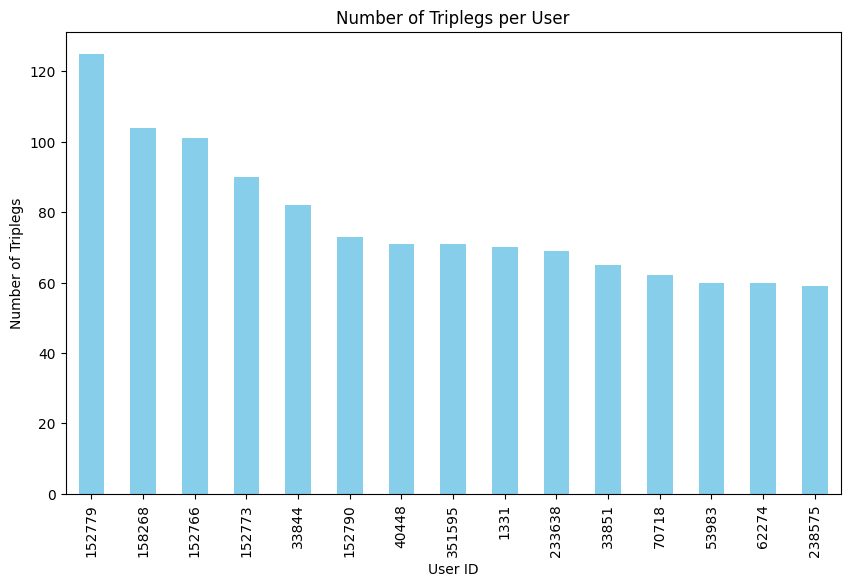

In [92]:
tripperuser(sequences)

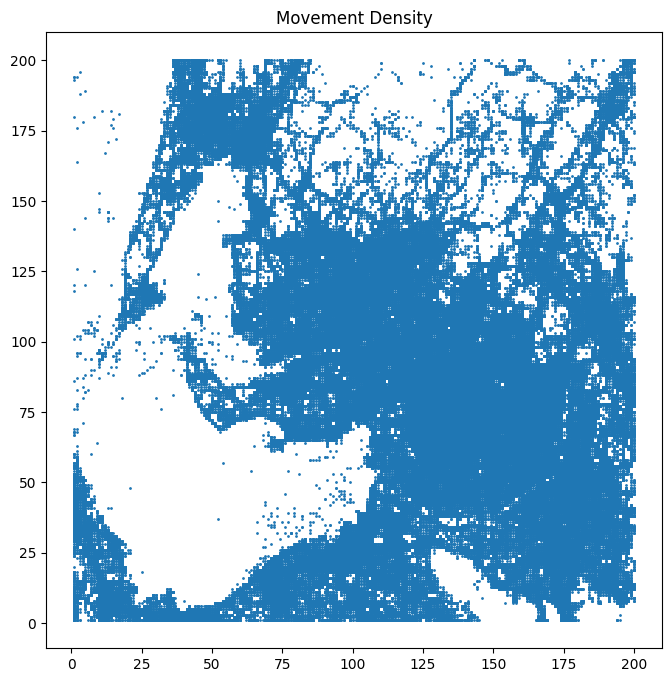

In [93]:
movden(sequences)

count    393807.000000
mean        143.167161
std         147.815883
min          30.000000
25%          60.000000
50%          90.000000
75%         180.000000
max        3780.000000
Name: duration, dtype: float64


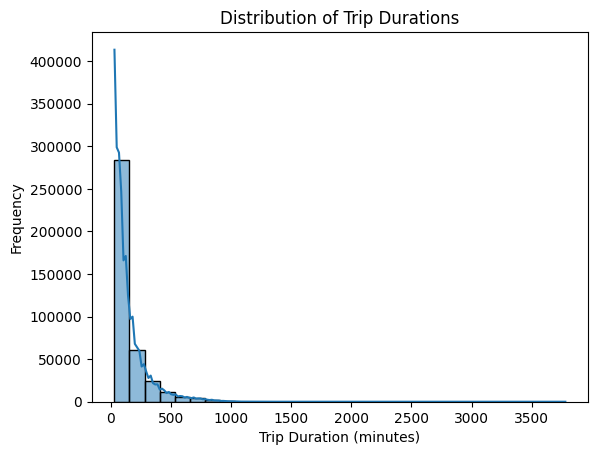

In [94]:
trip_duration(dftrip)

/var/folders/zw/vjq4r50178jg1mzk39cztpbh0000gn/T/ipykernel_22008/3340220425.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_users_dftrip['geom'] = top_users_dftrip['geom'].apply(parse_linestring)


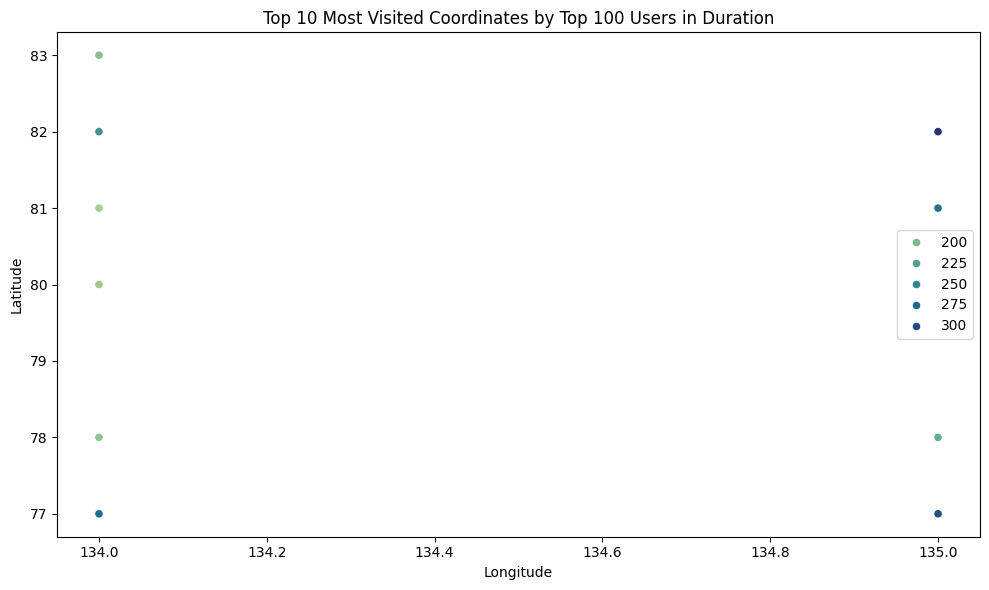

In [95]:
top_user_coord(dftrip)

## sequences analysis

The average length of the patterns is: 2.5658447317176174


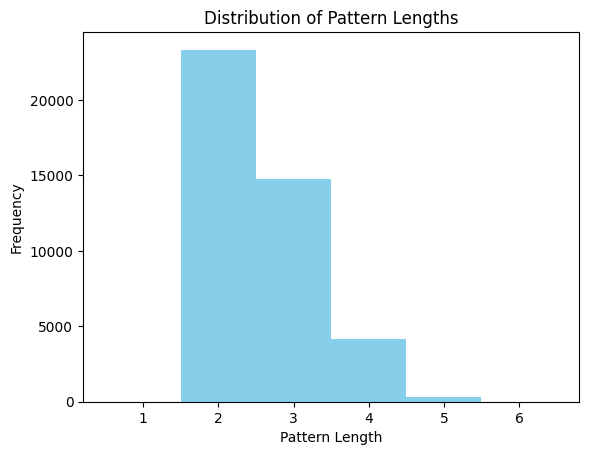

In [104]:
patterlen(dftest)

In [105]:
# common coordinate pairs

common_xy_df = commonxy(exploded_df)
common_xy_df.head(15)

,xy_pair,count
0,"(102, 122)",585
1,"(121, 78)",514
2,"(105, 121)",488
3,"(81, 115)",401
4,"(122, 78)",386
5,"(152, 128)",380
6,"(111, 119)",373
7,"(121, 80)",371
8,"(161, 96)",368
9,"(85, 144)",354


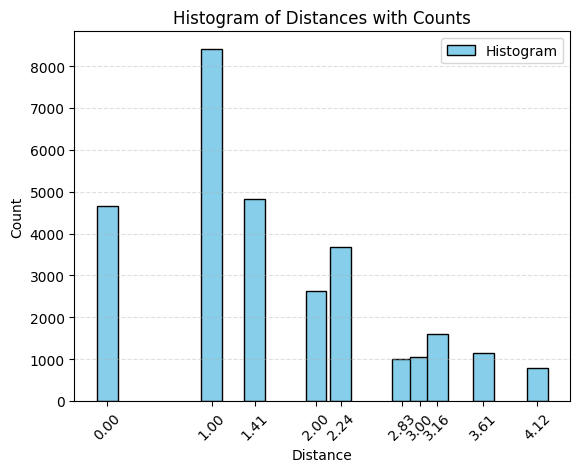

In [106]:
# distance between first and last coordinate in a frequent sequence

dftest = distancecalc(dftest)
value_counts = dftest['distance'].value_counts().head(10)
plotdistance(value_counts)

In [107]:
# distance between x or y coordinates in frequent sequences where only one coordinate changes

dftest['difference'] = dftest['coordinates'].apply(first_last)

dftest.dropna()
dftest['difference'].value_counts()

difference
0.0    29092
1.0     8411
2.0     2636
3.0     1047
Name: count, dtype: int64

[(('102', '122'), 588), (('121', '78'), 516), (('105', '121'), 488), (('81', '115'), 405), (('122', '78'), 386), (('152', '128'), 380), (('111', '119'), 373), (('121', '80'), 371), (('161', '96'), 368), (('85', '144'), 354)]


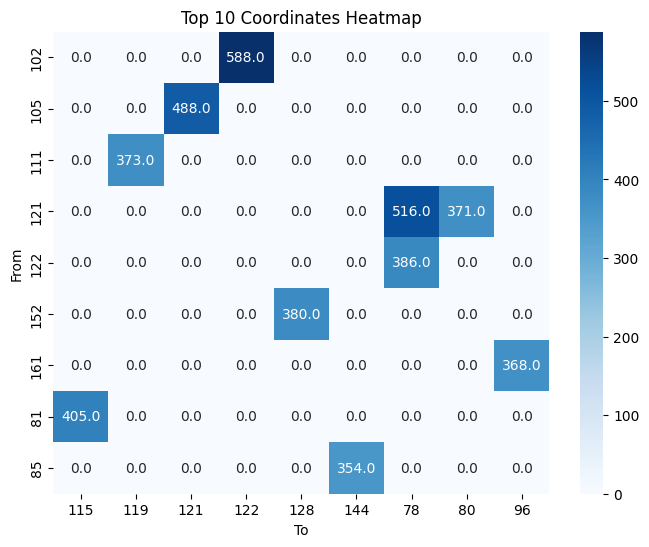

In [108]:
heatmaptrans(dftest)

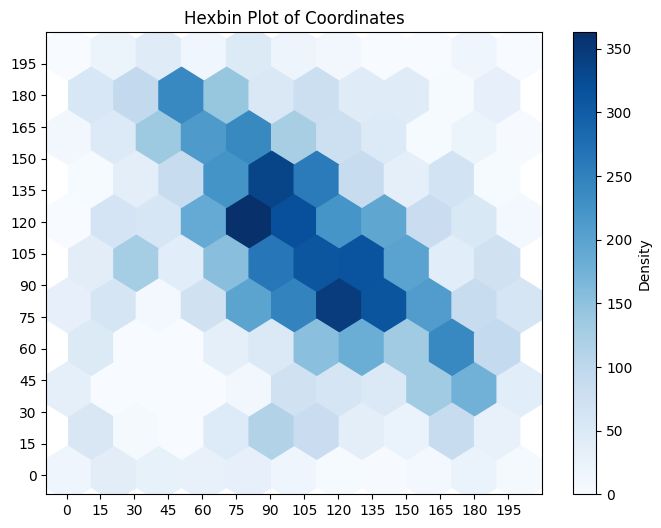

In [109]:
hexbincoord(dftest)

# City B data

In [18]:
dfc = pd.read_csv('frequent_sequences_B.csv')

#dftest = dfc.sample(n=50)
dftest = dfc

# Function to extract all coordinates from a sequence string
def extract_coordinates(sequence):
    return re.findall(r'(\d+),\s*(\d+)', sequence)

# Apply the function to extract coordinates
dftest['coordinates'] = dftest['Sequence'].apply(extract_coordinates)

# Explode the list of coordinates into separate rows
exploded_df = dftest.explode('coordinates', ignore_index=False)

# Split the coordinates into x and y
exploded_df[['x', 'y']] = pd.DataFrame(
    exploded_df['coordinates'].apply(lambda coord: list(map(int, coord))).tolist(), 
    index=exploded_df.index
)

exploded_df['index'] = exploded_df.index

# Drop the original columns for clarity if needed
exploded_df = exploded_df.drop(columns=['Sequence', 'coordinates'])


In [19]:
dftrip = pd.read_csv('triplegsB.csv')   

# Split long triplegs into shorter sub-triplegs
dftrip = triplegs_split(dftrip)

# Preprocess the data and limit to the first month
sequences = process_triplegs_data(dftrip)

In [20]:
# Ensure started_at and finished_at are in datetime format
dftrip['started_at'] = pd.to_datetime(dftrip['started_at'])
dftrip['finished_at'] = pd.to_datetime(dftrip['finished_at'])

# Calculate duration in minutes
dftrip['duration'] = (dftrip['finished_at'] - dftrip['started_at']).dt.total_seconds() / 60

## triplegs analysis

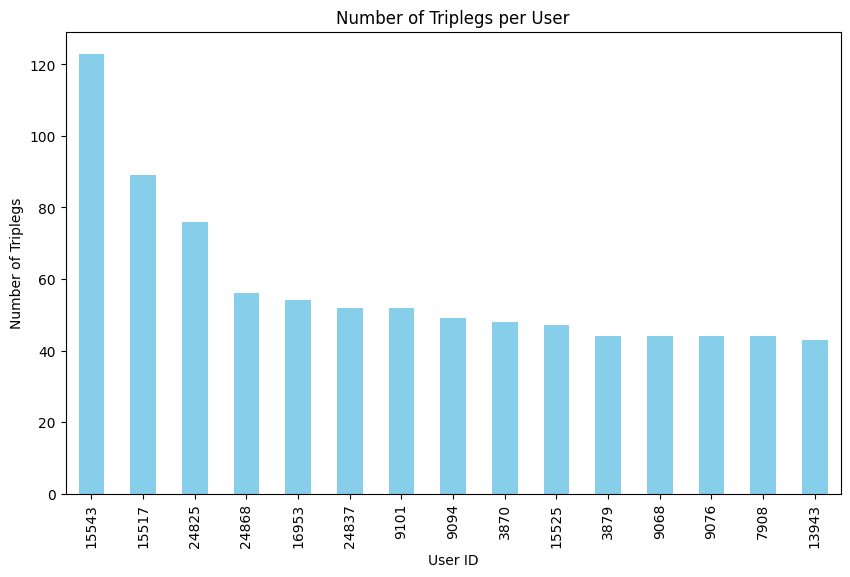

In [21]:
tripperuser(sequences)

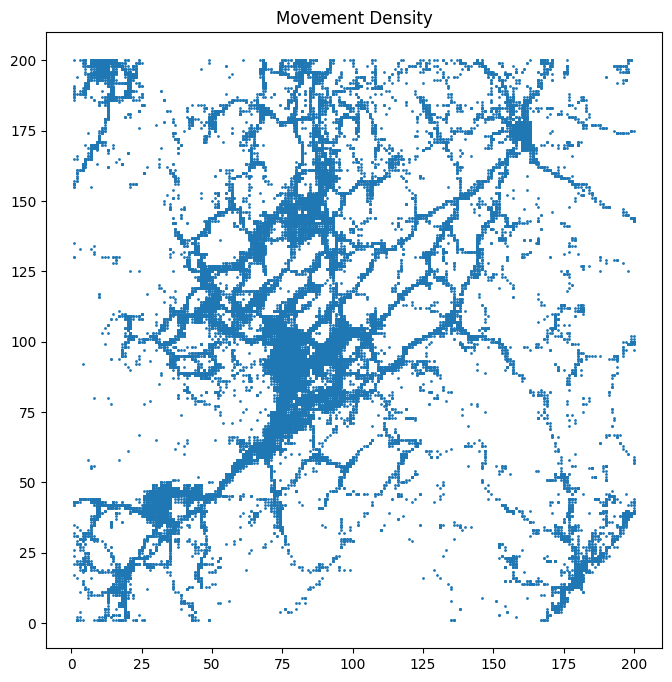

In [22]:
movden(sequences)

count    48568.000000
mean       141.488223
std        147.619461
min         30.000000
25%         60.000000
50%         90.000000
75%        180.000000
max       3870.000000
Name: duration, dtype: float64


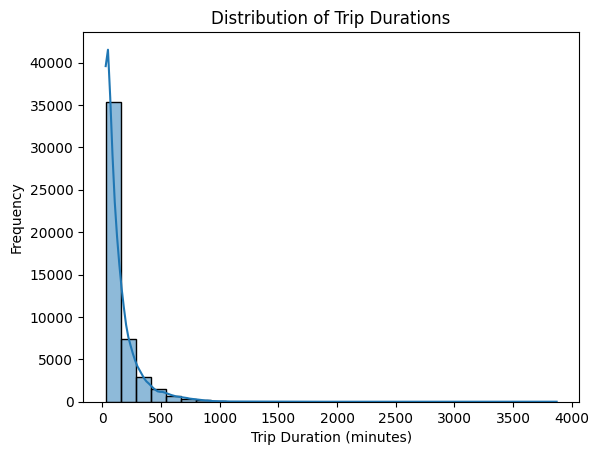

In [23]:
trip_duration(dftrip)

C:\Users\pooh_\AppData\Local\Temp\ipykernel_29188\3340220425.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_users_dftrip['geom'] = top_users_dftrip['geom'].apply(parse_linestring)


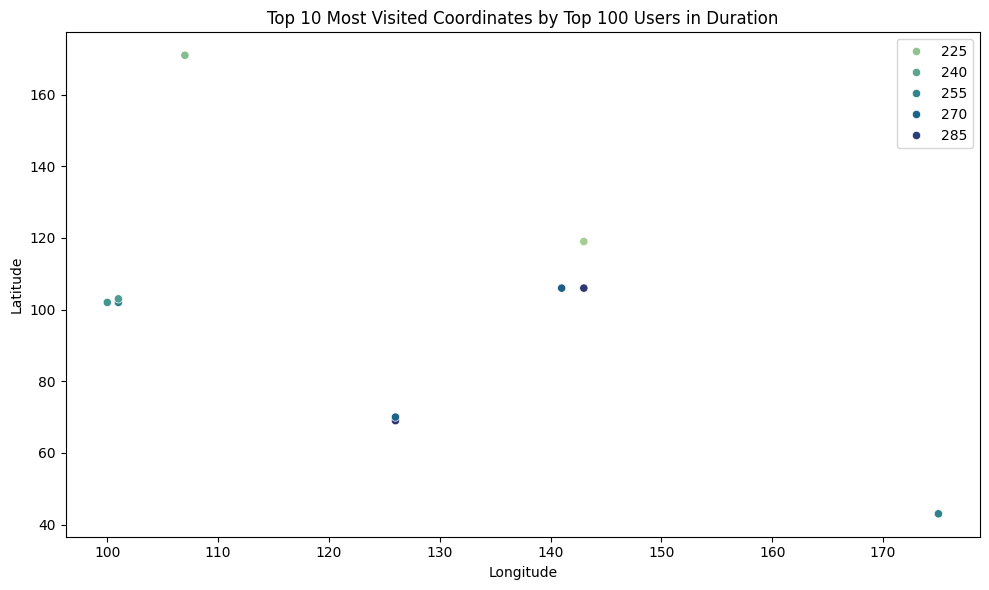

In [76]:
top_user_coord(dftrip)

## sequences analysis

The average length of the patterns is: 2.4138469222125107


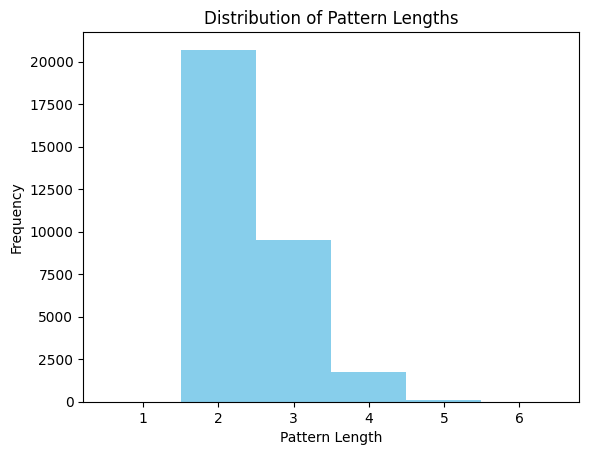

In [25]:
patterlen(dftest)

In [26]:
# common coordinate pairs

common_xy_df = commonxy(exploded_df)
common_xy_df.head(15)

,xy_pair,count
0,"(49, 113)",556
1,"(80, 92)",548
2,"(79, 92)",544
3,"(79, 93)",538
4,"(80, 95)",482
5,"(79, 94)",433
6,"(78, 93)",402
7,"(49, 112)",380
8,"(80, 96)",359
9,"(50, 113)",348


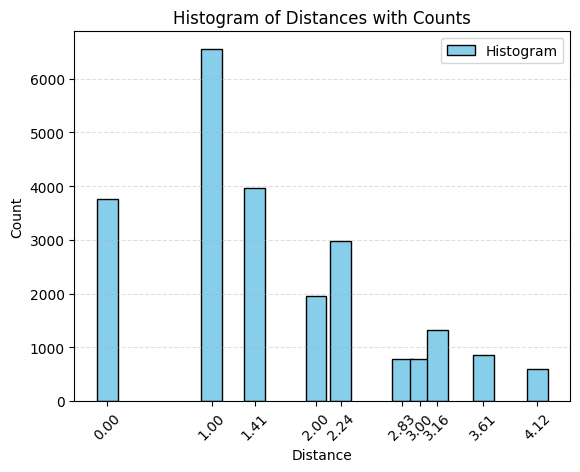

In [27]:
# distance between first and last coordinate in a frequent sequence

dftest = distancecalc(dftest)
value_counts = dftest['distance'].value_counts().head(10)
plotdistance(value_counts)

In [28]:
# distance between x or y coordinates in frequent sequences where only one coordinate changes

dftest['difference'] = dftest['coordinates'].apply(first_last)

dftest.dropna()
dftest['difference'].value_counts()

difference
0.0    21743
1.0     6553
2.0     1960
3.0      781
Name: count, dtype: int64

[(('80', '92'), 558), (('49', '113'), 556), (('79', '92'), 555), (('79', '93'), 538), (('80', '95'), 485), (('79', '94'), 435), (('78', '93'), 411), (('49', '112'), 380), (('80', '96'), 365), (('80', '93'), 349)]


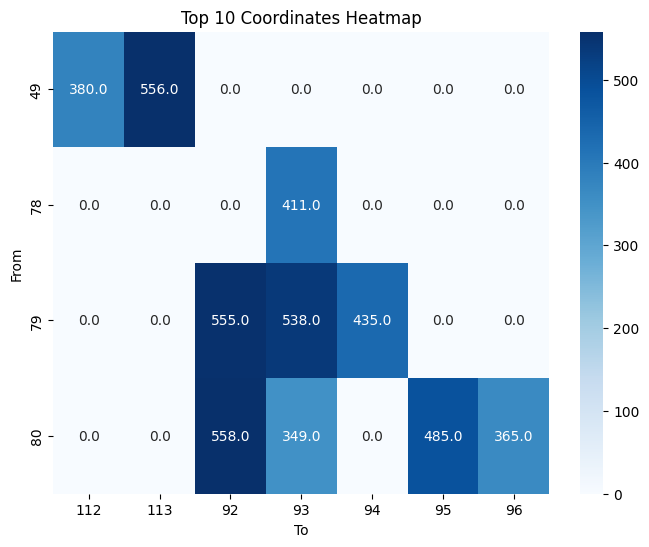

In [29]:
heatmaptrans(dftest)

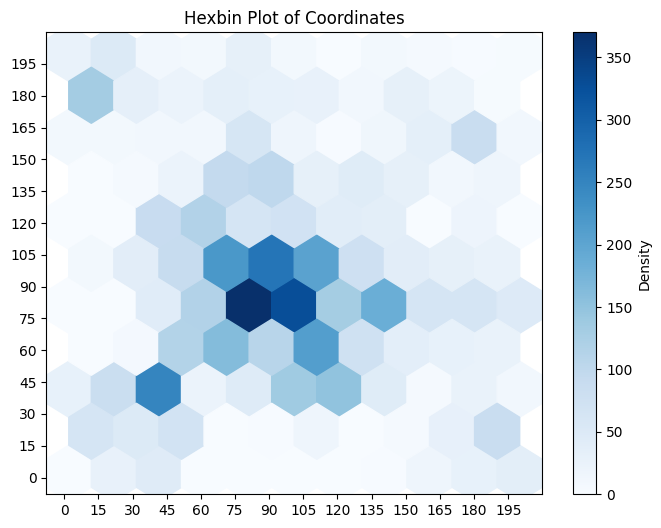

In [30]:
hexbincoord(dftest)

# City C data

In [31]:
dfc = pd.read_csv('frequent_sequences_C.csv')

#dftest = dfc.sample(n=50)
dftest = dfc

# Function to extract all coordinates from a sequence string
def extract_coordinates(sequence):
    return re.findall(r'(\d+),\s*(\d+)', sequence)

# Apply the function to extract coordinates
dftest['coordinates'] = dftest['Sequence'].apply(extract_coordinates)

# Explode the list of coordinates into separate rows
exploded_df = dftest.explode('coordinates', ignore_index=False)

# Split the coordinates into x and y
exploded_df[['x', 'y']] = pd.DataFrame(
    exploded_df['coordinates'].apply(lambda coord: list(map(int, coord))).tolist(), 
    index=exploded_df.index
)

exploded_df['index'] = exploded_df.index

# Drop the original columns for clarity if needed
exploded_df = exploded_df.drop(columns=['Sequence', 'coordinates'])


In [32]:
dftrip = pd.read_csv('triplegsC.csv')   

# Split long triplegs into shorter sub-triplegs
dftrip = triplegs_split(dftrip)

# Preprocess the data and limit to the first month
sequences = process_triplegs_data(dftrip)

In [33]:
# Ensure started_at and finished_at are in datetime format
dftrip['started_at'] = pd.to_datetime(dftrip['started_at'])
dftrip['finished_at'] = pd.to_datetime(dftrip['finished_at'])

# Calculate duration in minutes
dftrip['duration'] = (dftrip['finished_at'] - dftrip['started_at']).dt.total_seconds() / 60

## triplegs analysis

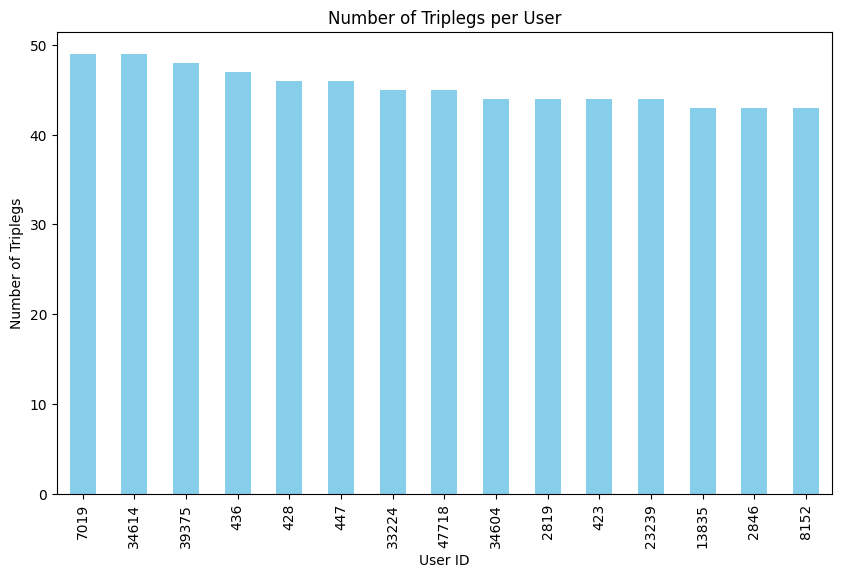

In [34]:
tripperuser(sequences)

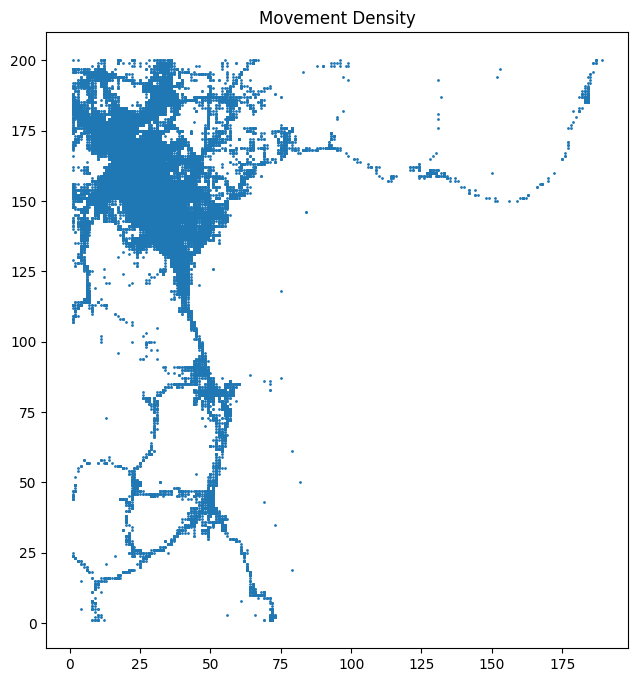

In [35]:
movden(sequences)

count    48478.000000
mean       138.181443
std        146.457539
min         30.000000
25%         30.000000
50%         90.000000
75%        180.000000
max       1620.000000
Name: duration, dtype: float64


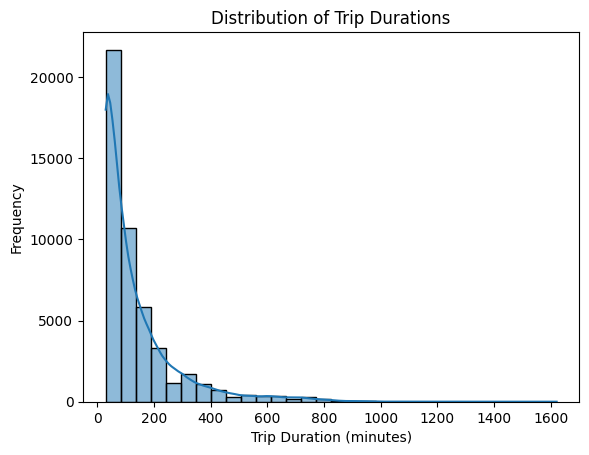

In [36]:
trip_duration(dftrip)

C:\Users\pooh_\AppData\Local\Temp\ipykernel_29188\3340220425.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_users_dftrip['geom'] = top_users_dftrip['geom'].apply(parse_linestring)


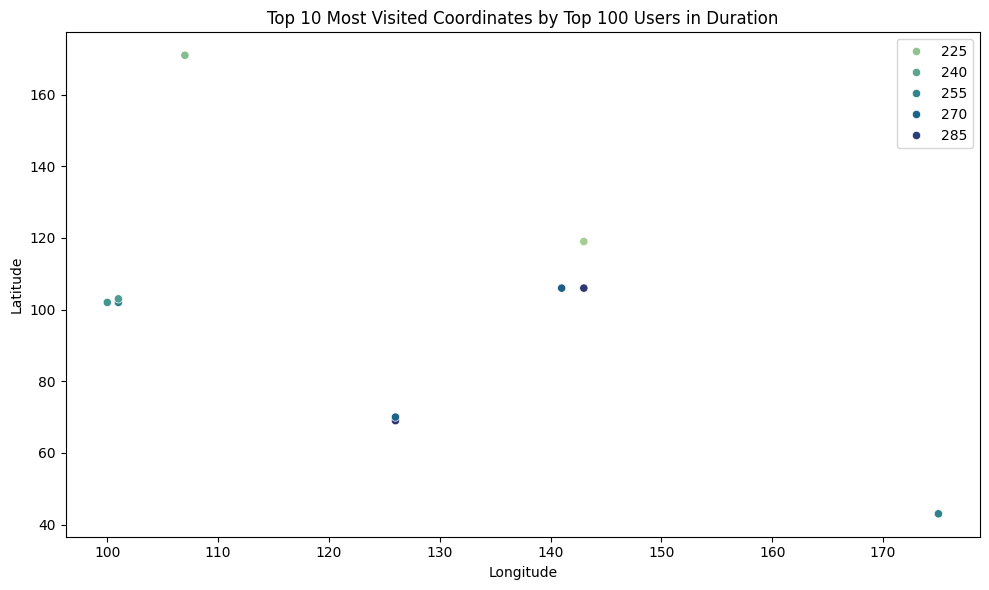

In [70]:
top_user_coord(dftrip)

## sequences analysis

The average length of the patterns is: 2.324804828445844


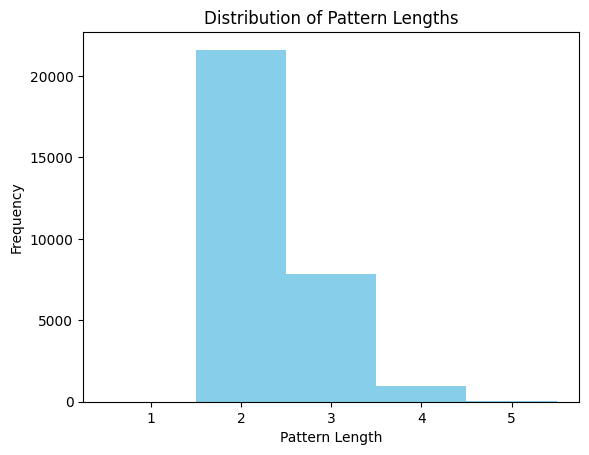

In [38]:
patterlen(dftest)

In [39]:
# common coordinate pairs

common_xy_df = commonxy(exploded_df)
common_xy_df.head(15)

,xy_pair,count
0,"(26, 153)",1034
1,"(24, 153)",946
2,"(25, 153)",887
3,"(24, 154)",550
4,"(24, 151)",548
5,"(24, 152)",459
6,"(22, 152)",455
7,"(26, 152)",435
8,"(25, 154)",428
9,"(14, 152)",399


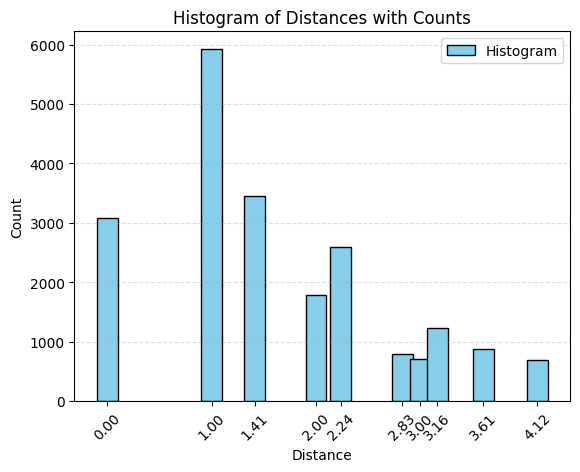

In [40]:
# distance between first and last coordinate in a frequent sequence

dftest = distancecalc(dftest)
value_counts = dftest['distance'].value_counts().head(10)
plotdistance(value_counts)

In [41]:
# distance between x or y coordinates in frequent sequences where only one coordinate changes

dftest['difference'] = dftest['coordinates'].apply(first_last)

dftest.dropna()
dftest['difference'].value_counts()

difference
0.0    20948
1.0     5926
2.0     1790
3.0      709
Name: count, dtype: int64

[(('26', '153'), 1034), (('24', '153'), 946), (('25', '153'), 887), (('24', '154'), 550), (('24', '151'), 548), (('153', '24'), 513), (('24', '152'), 459), (('22', '152'), 455), (('26', '152'), 435), (('25', '154'), 428)]


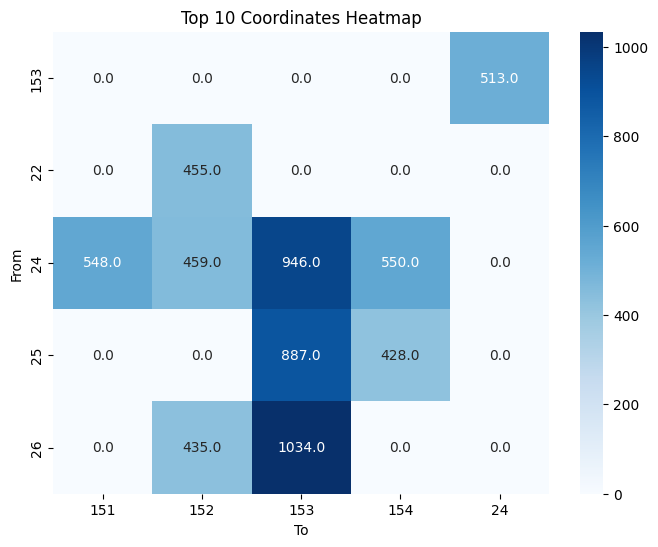

In [42]:
heatmaptrans(dftest)

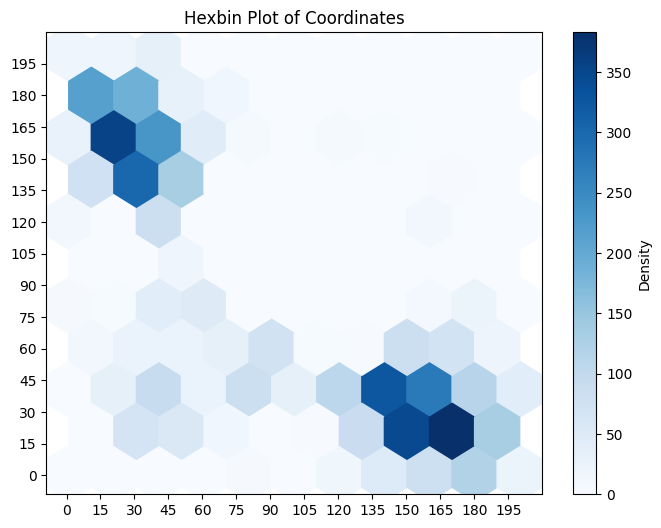

In [43]:
hexbincoord(dftest)

# City D data

In [44]:
dfc = pd.read_csv('frequent_sequences_D.csv')

#dftest = dfc.sample(n=50)
dftest = dfc

# Function to extract all coordinates from a sequence string
def extract_coordinates(sequence):
    return re.findall(r'(\d+),\s*(\d+)', sequence)

# Apply the function to extract coordinates
dftest['coordinates'] = dftest['Sequence'].apply(extract_coordinates)

# Explode the list of coordinates into separate rows
exploded_df = dftest.explode('coordinates', ignore_index=False)

# Split the coordinates into x and y
exploded_df[['x', 'y']] = pd.DataFrame(
    exploded_df['coordinates'].apply(lambda coord: list(map(int, coord))).tolist(), 
    index=exploded_df.index
)

exploded_df['index'] = exploded_df.index

# Drop the original columns for clarity if needed
exploded_df = exploded_df.drop(columns=['Sequence', 'coordinates'])


In [45]:
dftrip = pd.read_csv('triplegsD.csv')   

# Split long triplegs into shorter sub-triplegs
dftrip = triplegs_split(dftrip)

# Preprocess the data and limit to the first month
sequences = process_triplegs_data(dftrip)

In [46]:
# Ensure started_at and finished_at are in datetime format
dftrip['started_at'] = pd.to_datetime(dftrip['started_at'])
dftrip['finished_at'] = pd.to_datetime(dftrip['finished_at'])

# Calculate duration in minutes
dftrip['duration'] = (dftrip['finished_at'] - dftrip['started_at']).dt.total_seconds() / 60

## triplegs analysis

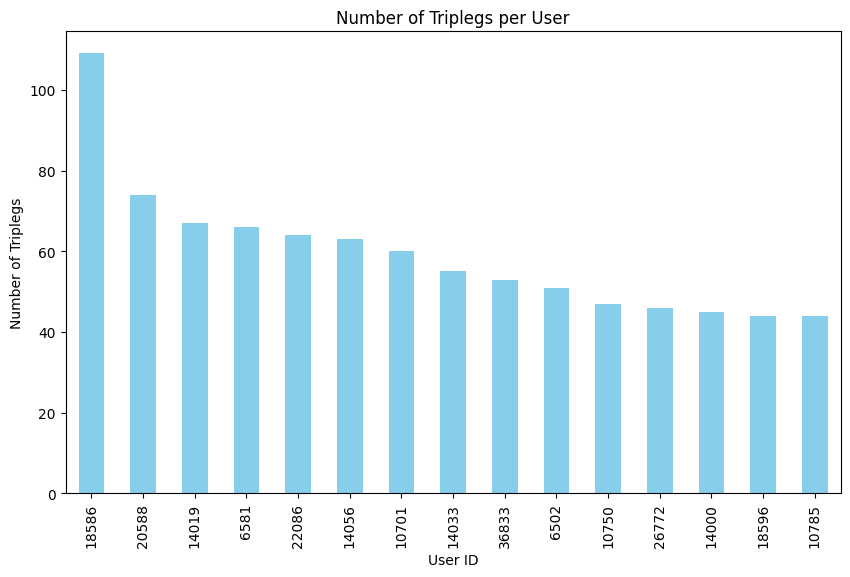

In [47]:
tripperuser(sequences)

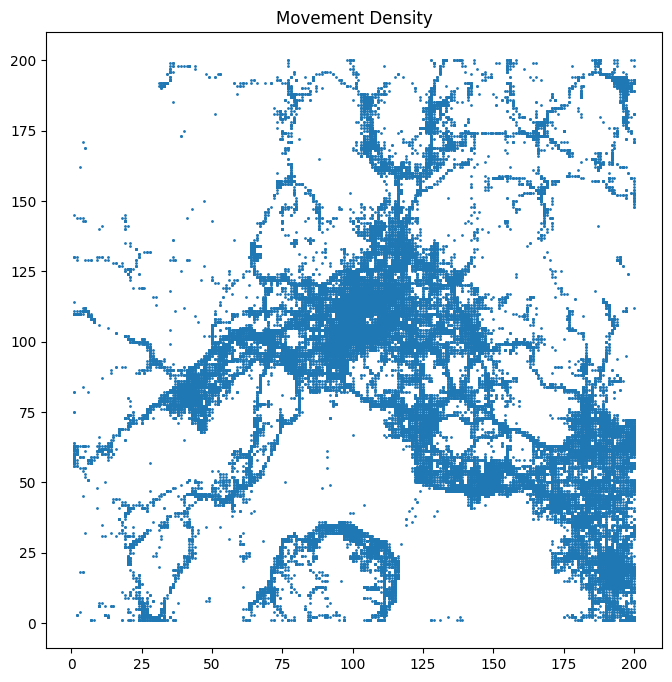

In [48]:
movden(sequences)

count    41867.000000
mean       177.290706
std        176.697815
min         30.000000
25%         60.000000
50%        120.000000
75%        240.000000
max       3300.000000
Name: duration, dtype: float64


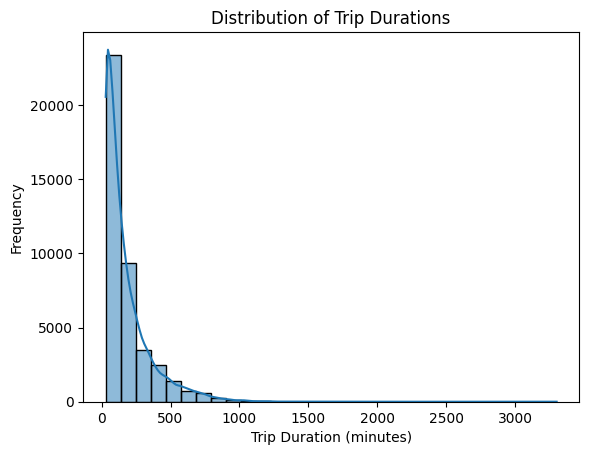

In [49]:
trip_duration(dftrip)

C:\Users\pooh_\AppData\Local\Temp\ipykernel_29188\3340220425.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_users_dftrip['geom'] = top_users_dftrip['geom'].apply(parse_linestring)


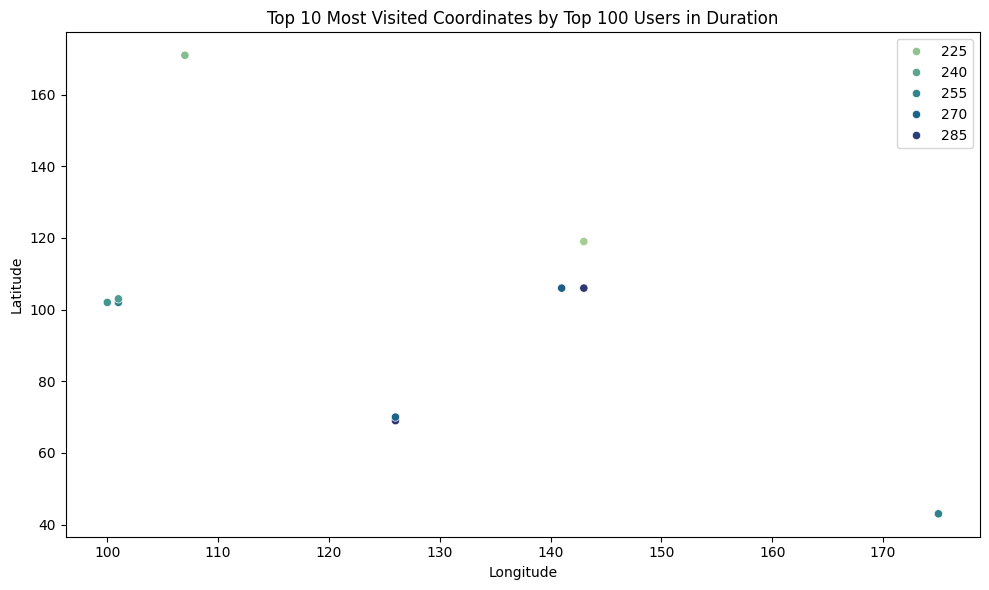

In [71]:
top_user_coord(dftrip)

## sequences analysis

The average length of the patterns is: 2.50542532924708


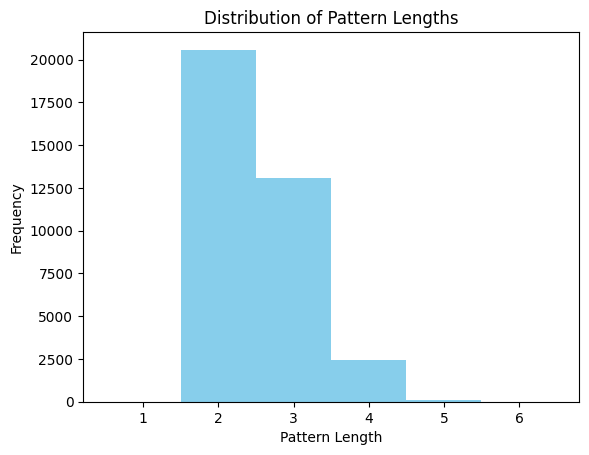

In [51]:
patterlen(dftest)

In [52]:
# common coordinate pairs

common_xy_df = commonxy(exploded_df)
common_xy_df.head(15)

,xy_pair,count
0,"(101, 102)",816
1,"(101, 103)",643
2,"(100, 102)",565
3,"(100, 101)",377
4,"(102, 108)",304
5,"(94, 104)",299
6,"(102, 103)",297
7,"(100, 104)",284
8,"(100, 103)",282
9,"(102, 109)",272


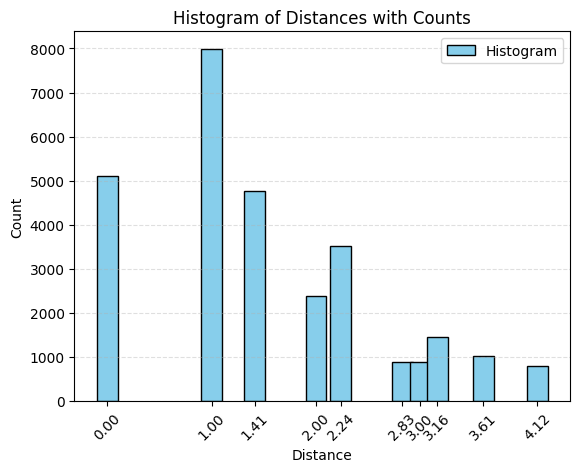

In [53]:
# distance between first and last coordinate in a frequent sequence

dftest = distancecalc(dftest)
value_counts = dftest['distance'].value_counts().head(10)
plotdistance(value_counts)

In [54]:
# distance between x or y coordinates in frequent sequences where only one coordinate changes

dftest['difference'] = dftest['coordinates'].apply(first_last)

dftest.dropna()
dftest['difference'].value_counts()

difference
0.0    23982
1.0     7988
2.0     2386
3.0      884
Name: count, dtype: int64

[(('101', '102'), 852), (('101', '103'), 677), (('100', '102'), 599), (('100', '101'), 509), (('101', '101'), 373), (('102', '108'), 352), (('100', '100'), 350), (('102', '100'), 348), (('101', '100'), 344), (('102', '103'), 339)]


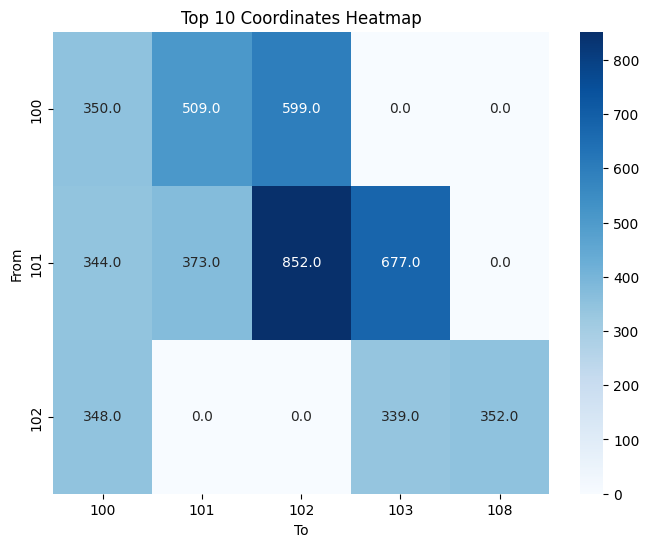

In [55]:
heatmaptrans(dftest)

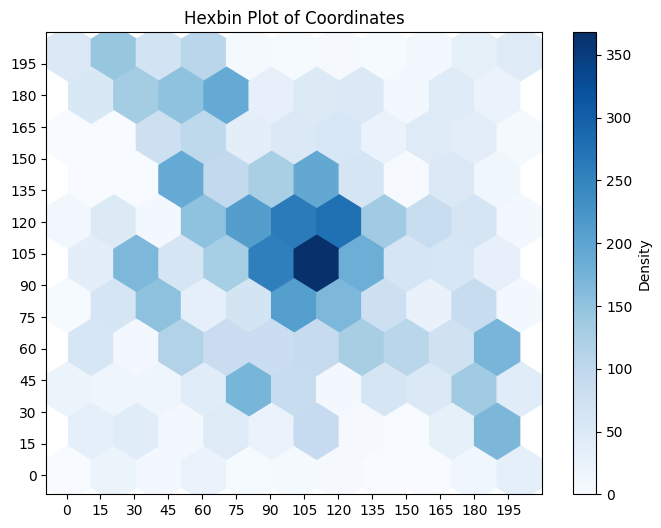

In [56]:
hexbincoord(dftest)